#Estudo de caso do número de visitantes diários na página da Wikipedia do ex-jogador da NFL Peyton Manning

## 1. Configuração do Ambiente e Ferramentas

In [ ]:
!pip install neuralprophet

In [ ]:
#pandas
#ploty
#sklearn
#prophet
#numpy
#matplotlib pyplot e seaborn
#statsmodels para decomposição da série

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

%matplotlib inline
sns.set(style='whitegrid')


##2. Análise Exploratória dos Dados (EDA)

###Limpeza e formatação

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/iaexpert_academy/Machine Learning/Classificação/Séries Temporais/page_wikipedia.csv')

In [ ]:
dataset.head()

,date,views
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [ ]:
dataset.tail()

,date,views
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


Data do primeiro registro: 10/12/2007
Data do último registro: 20/01/2016

In [ ]:
dataset.shape

(2905, 2)

In [ ]:
dataset.describe()

,views
count,2905.000000
mean,8.138958
std,0.845957
min,5.262690
25%,7.514800
50%,7.997999
75%,8.580168
max,12.846747


#### OBS: Já foi aplicado o logaritmo na coluna "views" da série. Isso é realizado para a estabilização da variância dos dados. Como veremos adiante, esses dados possuem dias em que há uma alta significativa no número de visualizações. Para acentuar essa variância e modelar a série de uma melhor maneira opta-se por trabalhar com o logaritimo.

In [ ]:
#Verificação dos tipos de objeto do dataset

dataset.dtypes

,0
date,object
views,float64


In [ ]:
#Renomear as colunas para o padrão de uso  da biblioteca Prophet

dataset = dataset[['date', 'views']].rename(columns = {'date': 'ds', 'views': 'y'})

In [ ]:
#Transformação da coluna "ds" em um objeto datetime

dataset['ds'] = pd.to_datetime(dataset['ds'])

In [ ]:
dataset

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


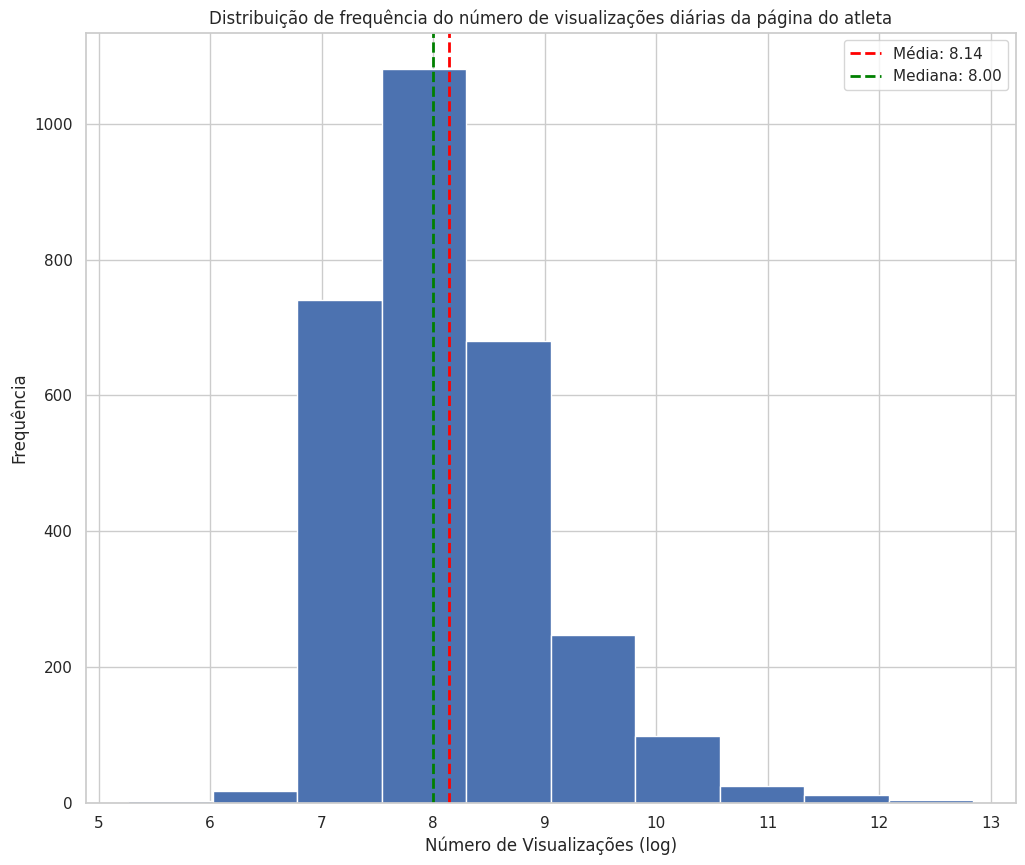

In [ ]:
mean_views = dataset['y'].mean()
median_views = dataset['y'].median()

dataset['y'].hist()
plt.axvline(mean_views, color='red', linestyle='dashed', linewidth=2, label=f'Média: {mean_views:.2f}')
plt.axvline(median_views, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {median_views:.2f}')
plt.title('Distribuição de frequência do número de visualizações diárias da página do atleta')
plt.xlabel('Número de Visualizações (log)')
plt.ylabel('Frequência')
plt.legend()
plt.show()

### Visualização da Série com a biblioteca Ploty

In [ ]:
fig = px.line(dataset, x = 'ds', y = 'y')
fig.show()
#superbowls jogados pelo atleta -> 2007, 2010, 2014, 2016

In [ ]:
#média móvel de 30 períodos da série
dataset_ma = dataset['y'].rolling(window = 30).mean()

In [ ]:
database = dataset.copy()

In [ ]:
database['y_ma'] = dataset_ma

In [ ]:
fig = px.line(database, x='ds', y=['y', 'y_ma'], title= 'Views com média móvel de 30 períodos')
fig.show()

In [ ]:
#Boxplot para uma análise sazonal da série

dataset['month'] = dataset['ds'].dt.month
dataset['day_of_week'] = dataset['ds'].dt.day_name()

In [ ]:
dataset.head()

,ds,y,month,day_of_week
0,2007-12-10,9.590761,12,Monday
1,2007-12-11,8.519590,12,Tuesday
2,2007-12-12,8.183677,12,Wednesday
3,2007-12-13,8.072467,12,Thursday
4,2007-12-14,7.893572,12,Friday


WARNING - (py.warnings._showwarnmsg) - /tmp/ipython-input-2276275929.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.






Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.





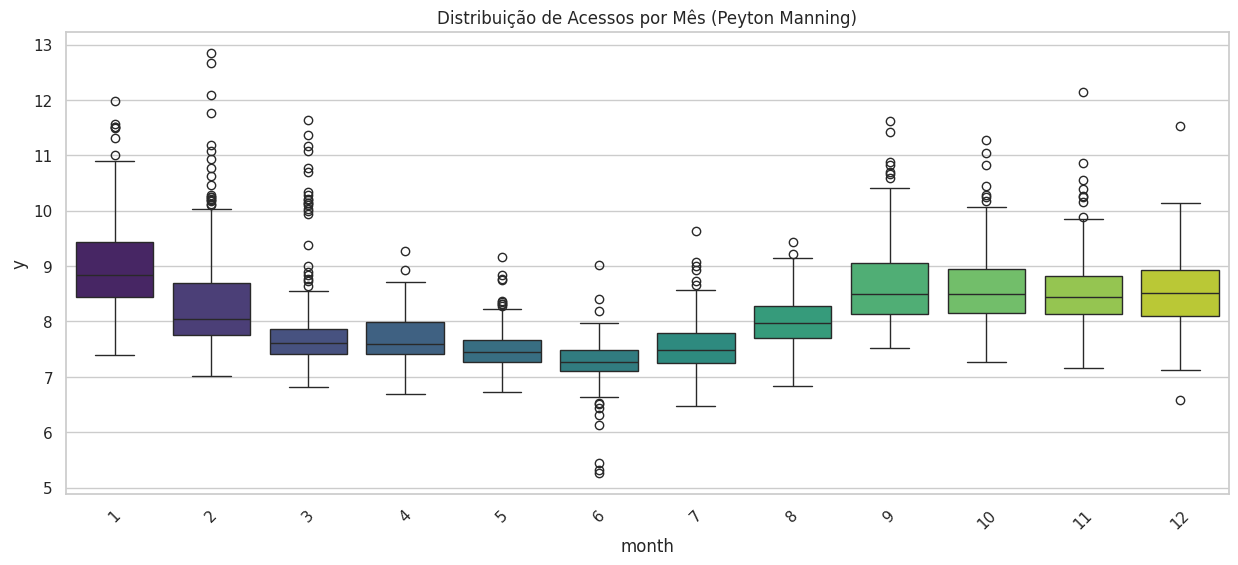

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(data = dataset, x = 'month', y = 'y', palette='viridis')
plt.title('Distribuição de Acessos por Mês (Peyton Manning)')
plt.xticks(rotation=45)
plt.show()

WARNING - (py.warnings._showwarnmsg) - /tmp/ipython-input-3179749927.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.






Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.





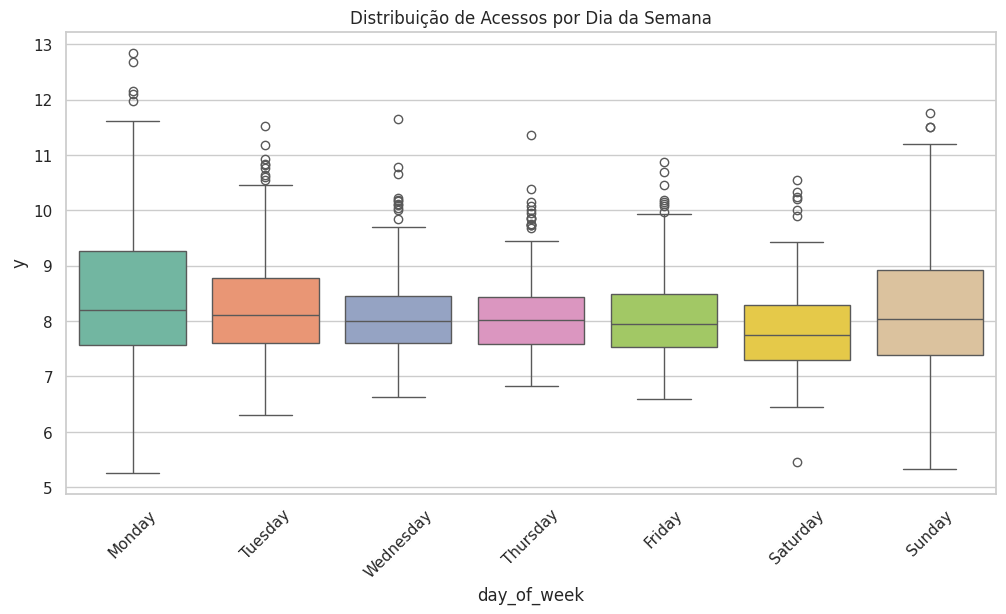

In [ ]:
plt.figure(figsize=(12, 6))
# Definindo a ordem para começar na segunda-feira
ordem_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.boxplot(x='day_of_week', y='y', data=dataset, order=ordem_dias, palette='Set2')
plt.title('Distribuição de Acessos por Dia da Semana')
plt.xticks(rotation=45)
plt.show()

###Decomposição Sazonal da Série

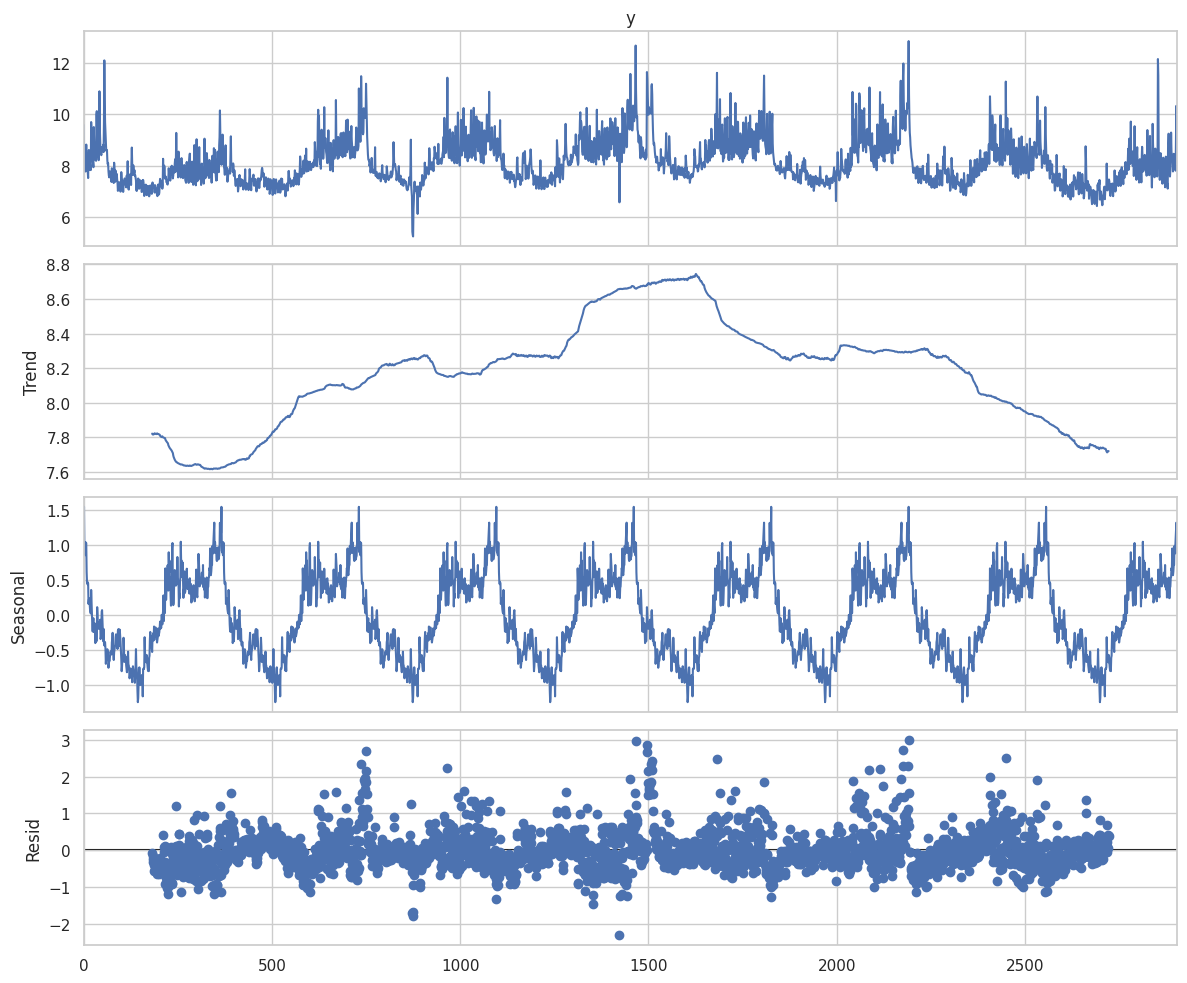

In [ ]:
##Dado que a série está em escala logarítmica, utilizaremos o modelo Aditivo, pois o log estabiliza a variância multiplicativa.
result = seasonal_decompose(dataset['y'], model='additive', period=365)

# Plotando de forma organizada
plt.rcParams['figure.figsize'] = (12, 10)
result.plot()
plt.show()

##3. Verificação Estatística

#### Implementação do teste de Dickey-Fuller (ADF) para verificação de estacionariedade


In [ ]:
result_adf = adfuller(dataset['y'])
print(result_adf[1])

0.00021068770095049506


Pelo ADF percebemos que a série é estacionária

####Gráficos ACF e PACF para entendimento da correlação de dias anteriores.

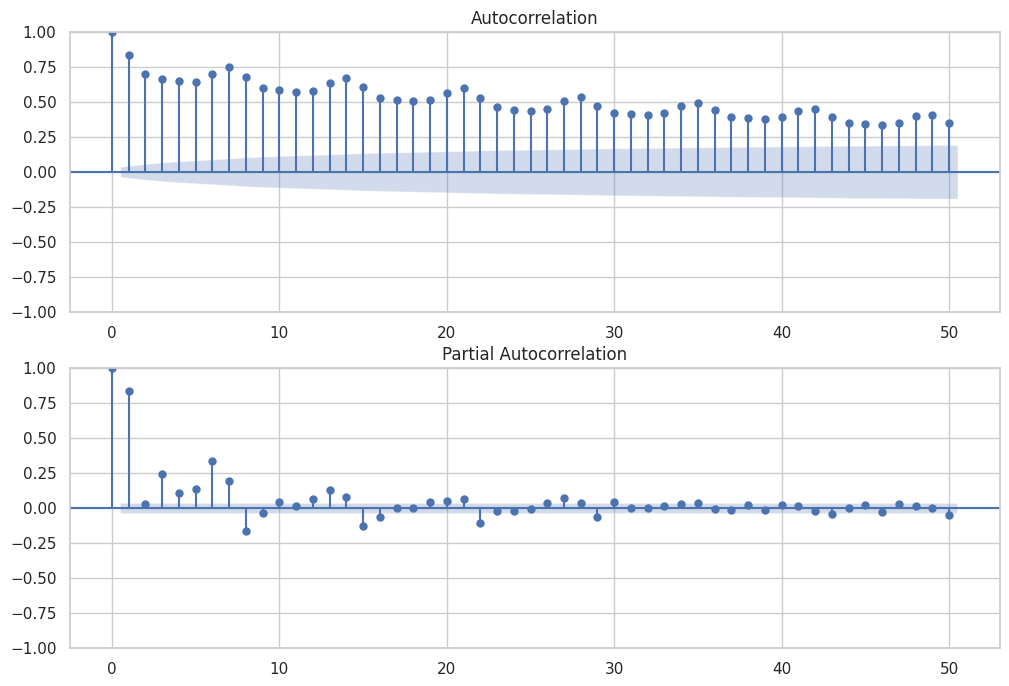

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(dataset['y'], lags=50, ax=ax1)
plot_pacf(dataset['y'], lags=50, ax=ax2)
plt.show()


- ACF com decaimento lento (possui memória longa)
- PACF significativo até aproximadamente o lag = 7. Restante dos atrasos não acrescenta muita informação.


##4. Modelagem com Prophet

In [ ]:
#padronizando novamente para uso no Prophet
dataset.drop(columns=['month', 'day_of_week'])

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


In [ ]:
#Treinamento da série usando a biblioteca
m = Prophet()

In [ ]:
m.fit(dataset)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=365)

In [ ]:
forecast = m.predict(future)

In [ ]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3265,2017-01-15,7.192195,7.468535,8.904566,6.838542,7.538780,1.017924,1.017924,1.017924,0.048287,0.048287,0.048287,0.969637,0.969637,0.969637,0.0,0.0,0.0,8.210119
3266,2017-01-16,7.191174,7.837721,9.234471,6.837633,7.539075,1.343970,1.343970,1.343970,0.352288,0.352288,0.352288,0.991682,0.991682,0.991682,0.0,0.0,0.0,8.535144
3267,2017-01-17,7.190152,7.578504,9.086167,6.834730,7.539369,1.132419,1.132419,1.132419,0.119636,0.119636,0.119636,1.012783,1.012783,1.012783,0.0,0.0,0.0,8.322571
3268,2017-01-18,7.189131,7.410311,8.904939,6.832946,7.539664,0.966070,0.966070,0.966070,-0.066669,-0.066669,-0.066669,1.032739,1.032739,1.032739,0.0,0.0,0.0,8.155201
3269,2017-01-19,7.188109,7.419139,8.918873,6.829716,7.539959,0.979048,0.979048,0.979048,-0.072254,-0.072254,-0.072254,1.051302,1.051302,1.051302,0.0,0.0,0.0,8.167158


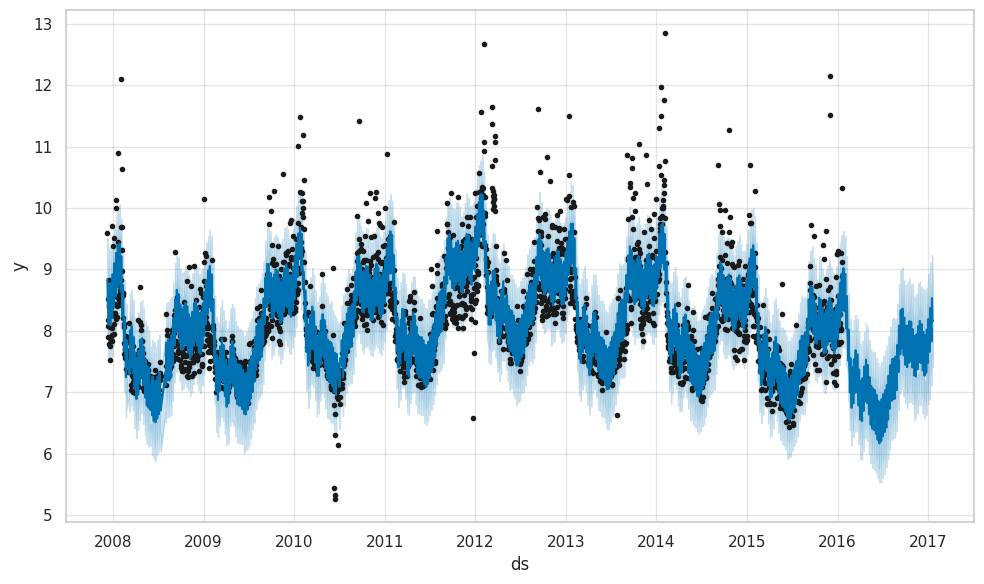

In [ ]:
fig_1 = m.plot(forecast)

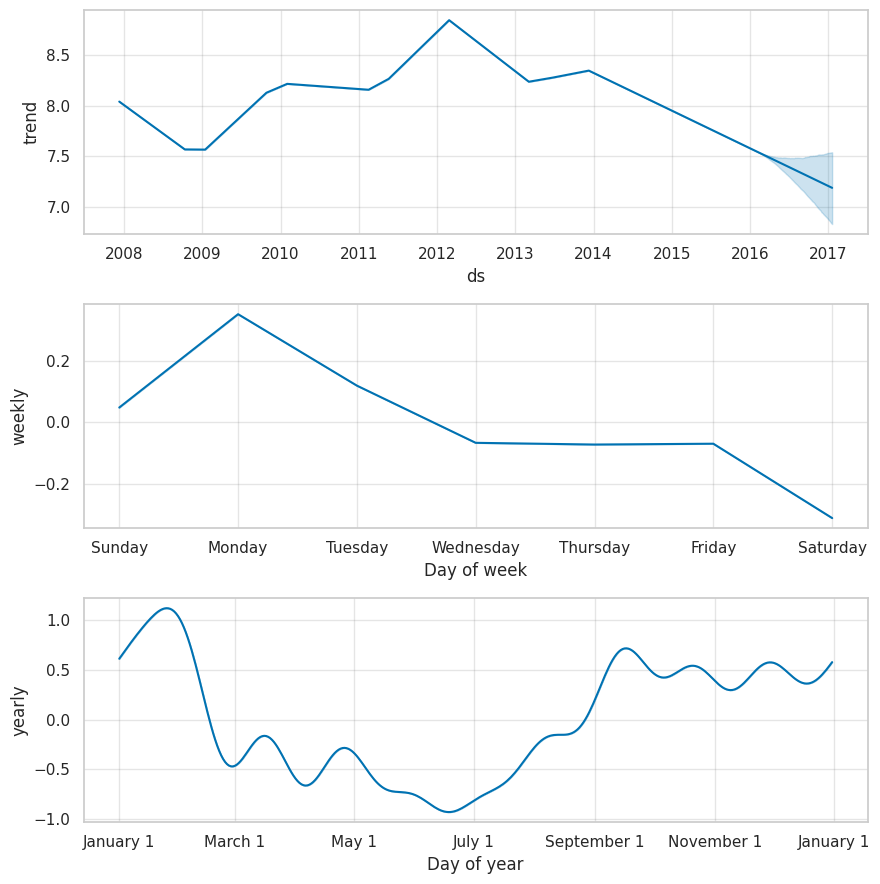

In [ ]:
fig_2 = m.plot_components(forecast)

### Incorporação de Eventos Especiais (Holidays)

In [ ]:
#Vamos adicionar alguma datas de picos de visualizações na modelagem de nossa série
#Procuramos graficamente quais são esses "dias especiais"

feriados = pd.DataFrame({
    'holiday' : 'superbowl',
    'ds' : pd.to_datetime(['2010-02-07', '2014-02-03', '2016-02-07']),
    'lower_window' : 0,
    'upper_window' : 1,
})

In [ ]:
feriados

,holiday,ds,lower_window,upper_window
0,superbowl,2010-02-07,0,1
1,superbowl,2014-02-03,0,1
2,superbowl,2016-02-07,0,1


In [ ]:
#Instanciar o modelo com o nosso parâmetro criado

m = Prophet(holidays = feriados)
m.fit(dataset)
forecast_2 = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


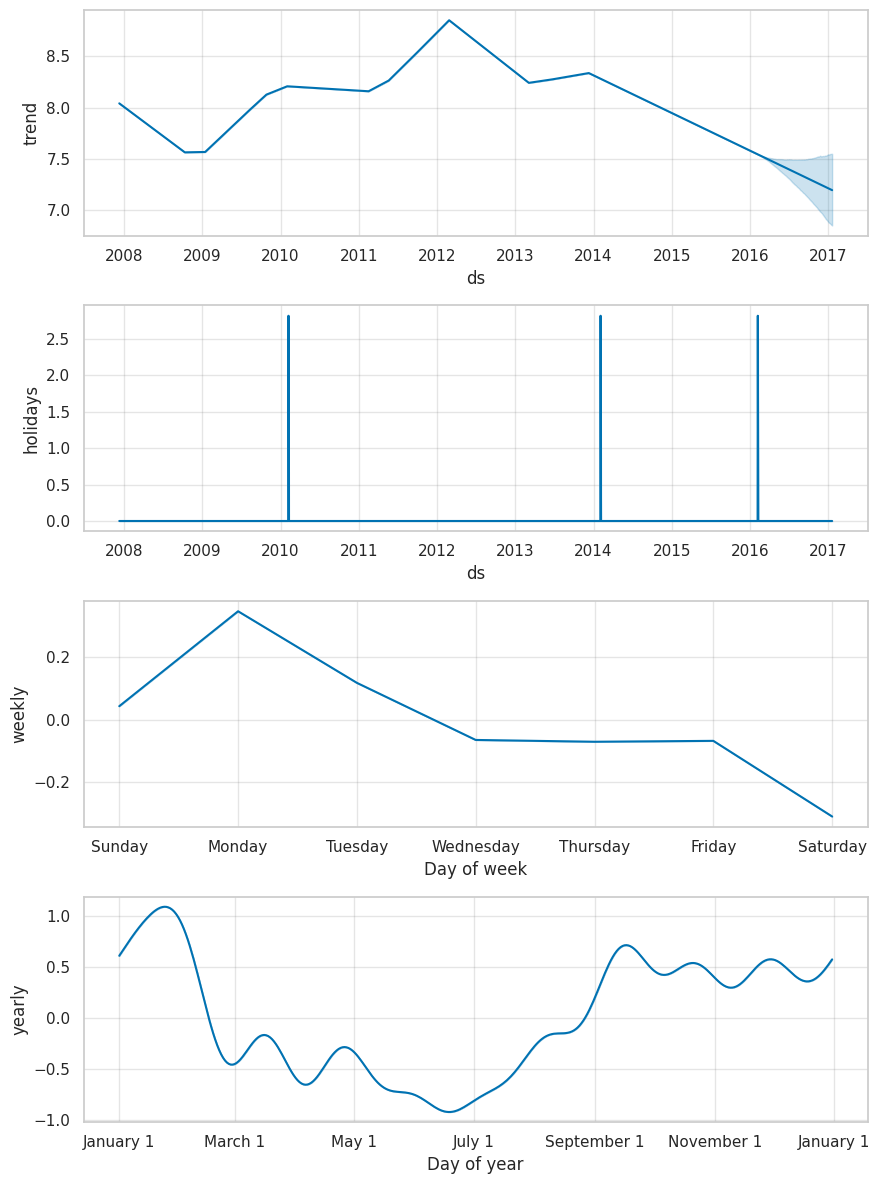

In [ ]:
fig_3 = m.plot_components(forecast_2)

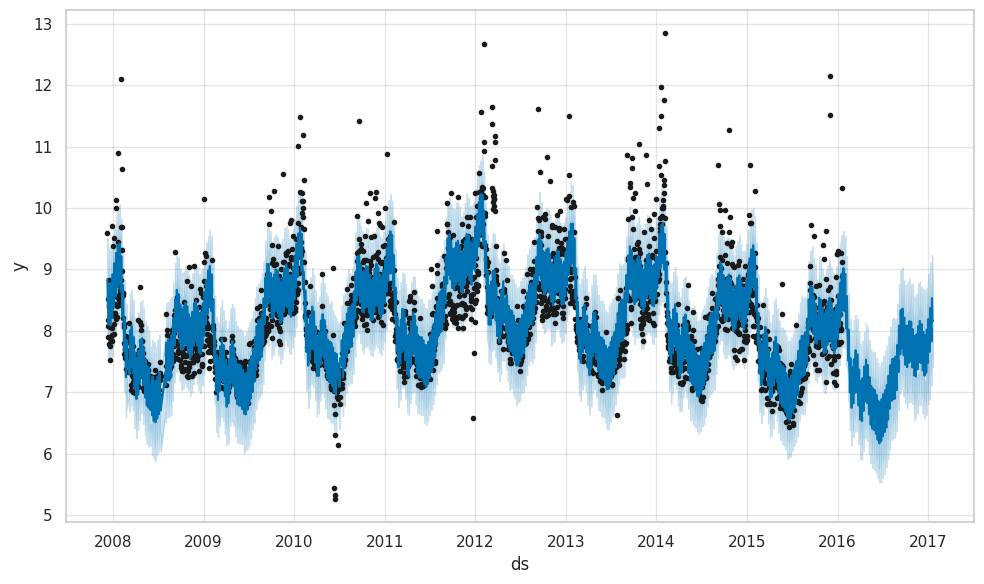

In [ ]:
fig_4 = m.plot(forecast)

##5. Avaliação de Performance


###Validação cruzada no Prophet

Período de 180 registros entre um teste e outro, com 730 dias de base para o ínicio da validação, com previsão de intervalo de 365 dias

In [ ]:
from prophet.diagnostics import cross_validation

ds_cross_valid = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')


INFO:prophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
## Vamos analisar algumas métricas de erro da nossa validação cruzada
from prophet.diagnostics import performance_metrics
ds_pf = performance_metrics(ds_cross_valid)
ds_pf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.462295,0.679923,0.492954,0.057239,0.050050,0.057538,0.684102
1,38 days,0.468001,0.684106,0.498038,0.057829,0.049784,0.058185,0.682960
2,39 days,0.490251,0.700179,0.504279,0.058448,0.050050,0.058927,0.680219
3,40 days,0.497637,0.705434,0.507107,0.058753,0.049499,0.059298,0.683874
4,41 days,0.505008,0.710639,0.507961,0.058819,0.049784,0.059424,0.690270


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/prophet/plot.py:548: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.




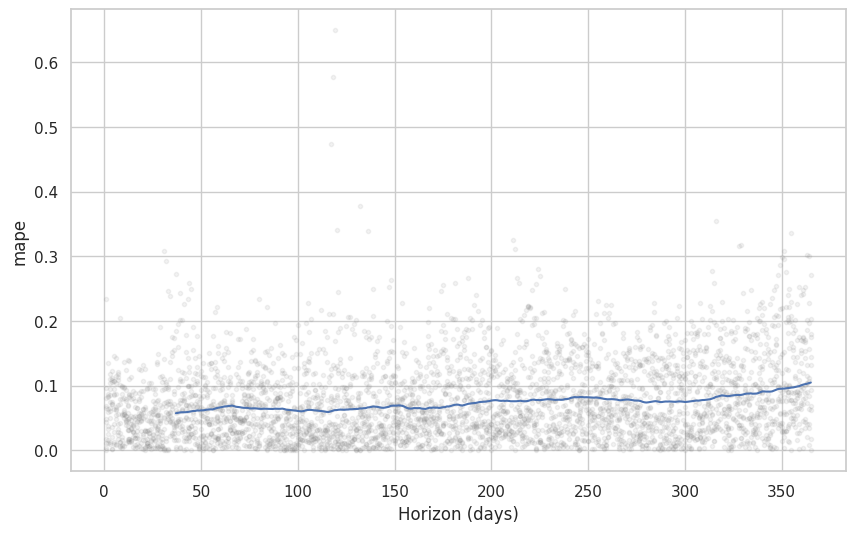

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(ds_cross_valid, metric='mape')


##Comparativo entre modelos Prophet, SARIMAX, e Neural Prophet

Vamos treinar os modelos com validação cruzada e fazer uma avaliação de desempenho.

In [ ]:
dataset.head()

,ds,y,month,day_of_week
0,2007-12-10,9.590761,12,Monday
1,2007-12-11,8.519590,12,Tuesday
2,2007-12-12,8.183677,12,Wednesday
3,2007-12-13,8.072467,12,Thursday
4,2007-12-14,7.893572,12,Friday


In [ ]:
dataset = dataset.drop(columns=['month', 'day_of_week'])

In [ ]:
print(len(dataset))

2905


In [ ]:
 #Criação de uma base de treinamento excluindo 365 dias da base original

train_size = len(dataset) - 365
print(train_size)

2540


In [ ]:
dataset_train = dataset.iloc[:train_size]
print(len(dataset_train))

2540


In [ ]:
dataset_test = dataset.iloc[train_size:]
print(len(dataset_test))

365


In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
#Treinando um modelo ARIMA com auto_arima

dataset_arima = auto_arima(dataset_train['y'],
                           m=7,
                           seasonal=True,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=2591.487, Time=25.72 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3540.537, Time=0.64 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3127.540, Time=4.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3178.190, Time=3.69 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3538.538, Time=0.18 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=2825.313, Time=11.40 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=2740.672, Time=13.85 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=2601.263, Time=20.43 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=2593.640, Time=19.27 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=2993.738, Time=5.32 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=2751.829, Time=20.03 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=2661.893, Time=9.73 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=2586.415, Time=22.35 sec
 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=2582.806, Time=20.71 sec
 ARIMA(1,1,2)(1,0,2)[7] i

In [ ]:
dataset_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 2540
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -1265.348
Date:                                Sat, 31 Jan 2026   AIC                           2550.696
Time:                                        20:55:35   BIC                           2609.091
Sample:                                             0   HQIC                          2571.879
                                               - 2540                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1740      0.094     12.469      0.000       0.989       1.359
ar.L2         -0.2301      0.079     -2.896      0.004      -0.386      -0.074
ma.L1         -1.5178      0.093    -16.276      0.000      -1.701      -1.335
ma.L2          0.3672      0.123      2.986      0.003       0.126       0.608
ma.L3          0.1546      0.038      4.070      0.000       0.080       0.229
ar.S.L7        0.9920      0.913      1.087      0.277      -0.797       2.781
ar.S.L14      -0.0979      0.814     -0.120      0.904      -1.693       1.497
ma.S.L7       -0.7808      0.911     -0.857      0.392      -2.567       1.006
ma.S.L14       0.0928      0.611      0.152      0.879      -1.105       1.291
sigma2         0.1600      0.002     74.296      0.000       0.156       0.164
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7802.68
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sarimax_predict = dataset_arima.predict(n_periods=len(dataset_test))

In [ ]:
sarimax_predict

,0
2540,9.315689
2541,9.078386
2542,8.786205
2543,8.679208
2544,8.711811
...,...
2900,8.743525
2901,8.743576
2902,8.743311
2903,8.744068


In [ ]:
from neuralprophet import NeuralProphet

# Instanciando
# Ele também aceita holidays, mas vamos testar o modelo puro primeiro para ver o poder da rede neural
m_neural = NeuralProphet(learning_rate=0.01)
# Treinando
metrics = m_neural.fit(dataset_train, freq="D")
if not hasattr(np, 'NaN'):
    np.NaN = np.nan
# Prevendo
# O NeuralProphet precisa de um dataframe futuro específico
future_neural = m_neural.make_future_dataframe(dataset_train, periods=len(dataset_test))
forecast_neural = m_neural.predict(future_neural)

# Extraindo apenas a predição final (yhat1)
preds_neural = forecast_neural['yhat1'].tail(len(dataset_test)).values

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.898% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.898% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an 

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.898% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.898% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralpr

Predicting: 40it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [ ]:
preds_neural

array([9.55233689, 9.33343018, 9.1374141 , 9.13150653, 9.14036926,
       8.9104499 , 9.25721842, 9.49975187, 9.259323  , 9.04078312,
       9.01318485, 9.00019299, 8.74932124, 9.07541406, 9.29774573,
       9.03850182, 8.80181475, 8.75682207, 8.72782037, 8.46201935,
       8.77496598, 8.98515391, 8.71511531, 8.4695169 , 8.41691139,
       8.38212313, 8.11220472, 8.42248464, 8.63184603, 8.3619309 ,
       8.11899155, 8.07041575, 8.04114856, 7.77779436, 8.0960777 ,
       8.31479239, 8.05610924, 7.8242888 , 7.78853223, 7.77254588,
       7.52374471, 7.85661576, 8.09129139, 7.84848642, 7.63287411,
       7.61323937, 7.61370235, 7.38120451, 7.73056681, 7.98051314,
       7.75308541, 7.55249989, 7.54713082, 7.56135825, 7.34154825,
       7.70297536, 7.96412172, 7.74692436, 7.55541161, 7.55839791,
       7.57995695, 7.36634666, 7.73323215, 7.9984787 , 7.7845577 ,
       7.59560378, 7.5999334 , 7.62175849, 7.40806461, 7.77336423,
       8.03746383, 7.82093758, 7.62913804, 7.62992114, 7.64774

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1. Recalcular Prophet para essa janela de treino e teste
m_prophet = Prophet(holidays=feriados)
m_prophet.fit(dataset_train)
future_prophet = m_prophet.make_future_dataframe(periods=len(dataset_test))
forecast_prophet = m_prophet.predict(future_prophet)
preds_prophet = forecast_prophet['yhat'].tail(len(dataset_test)).values

# Dataframe para comparação
comparativo = pd.DataFrame({
    'Data': dataset_test['ds'],
    'Real': dataset_test['y'],
    'Prophet': preds_prophet,
    'SARIMAX': sarimax_predict,
    'NeuralProphet': preds_neural
})

# Métricas de erro
print("--- Batalha dos Modelos (RMSE) ---")
print(f"Prophet: {mean_squared_error(comparativo['Real'], comparativo['Prophet']):.4f}")
print(f"SARIMAX: {mean_squared_error(comparativo['Real'], comparativo['SARIMAX']):.4f}")
print(f"NeuralProphet: {mean_squared_error(comparativo['Real'], comparativo['NeuralProphet']):.4f}")

# Erros percentuais
print("--- Batalha dos Modelos Percentual ---")
print(f"Prophet percentual: {mean_absolute_percentage_error(comparativo['Real'], comparativo['Prophet']):.4f}")
print(f"SARIMAX percentual: {mean_absolute_percentage_error(comparativo['Real'], comparativo['SARIMAX']):.4f}")
print(f"NeuralProphet percentual: {mean_absolute_percentage_error(comparativo['Real'], comparativo['NeuralProphet']):.4f}")

# 4. Plotagem
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=comparativo['Data'], y=comparativo['Real'], name='Real', line=dict(color='black')))
fig.add_trace(go.Scatter(x=comparativo['Data'], y=comparativo['Prophet'], name='Prophet', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=comparativo['Data'], y=comparativo['SARIMAX'], name='SARIMAX', line=dict(color='green')))
fig.add_trace(go.Scatter(x=comparativo['Data'], y=comparativo['NeuralProphet'], name='NeuralProphet', line=dict(color='red')))
fig.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--- Batalha dos Modelos (RMSE) ---
Prophet: 0.3520
SARIMAX: 1.5983
NeuralProphet: 0.3854
--- Batalha dos Modelos Percentual ---
Prophet percentual: 0.0578
SARIMAX percentual: 0.1528
NeuralProphet percentual: 0.0624
